In [1]:
import csv
import pandas as pd
import numpy as np
import json
import jsonlines
import re
csv.field_size_limit(100000000)
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, classification_report, log_loss
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse
%matplotlib inline 

import matplotlib.dates as mdates
import matplotlib.ticker as tick

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.4f}'.format

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# **Logostic Regression** 
## *(1) TweetsCov19*
#### (Content + User Features)

In [2]:
path = '../data/df_tweetscov19_sample_200000.tsv'

df_tweetscov19_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg', 'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num', 'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent', 'tweet_politic_polarisation', 'tweet_science_polarisation', 'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female', 'male' , 'work', 'leisure', 'home', 'money', 'relegion', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body', 'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear', 'feel', 'motion', 'space', 'time', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation', 'Is_deleted', 'user_vadercompound_average', 'tweet_vadercompound_abweichung', 'tweet_political_polarisation_abweichung', 'tweet_science_polarisation_abweichung', 'tweet_moderacy_polarisation_abweichung'])

print('Shape :', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape : (200000, 95)


Tweet_Id                          Username  Retweets  Favorites  \
0  1252651655616532480  98432e94b13942101ca1ab63145cb401         1          1   
1  1191671063760924672  6281afa4db32ffd9ca516f76b2f257eb       189        314   
2  1199273226066481152  fd186920eb4730f7b564903098a32579         1          1   
3  1242201195550314499  06b8219c72795f4a84ee9aa58e778786         0          0   
4  1190322195735535616  1917db1f6441a3891e78b89264c75155         1          1   

   Vader_neg  Vader_neu  Vader_pos  vader_com  Hashtags_num  Mentions_num  \
0    -0.1140     0.6680     0.2180     0.5859             0             0   
1    -0.4160     0.5010     0.0830    -0.8732             1             0   
2    -0.0000     0.8430     0.1570     0.7717             0             4   
3    -0.0000     1.0000     0.0000     0.0000             4             2   
4    -0.0540     0.8690     0.0770     0.4588             1            50   

   Text_len  URLs_num  readability  Emoji_num  Emoji_sent  \
0       174         0      63.4800          2      1.1800   
1       122         0      87.5500          7      1.5180   
2       192         0      57.7930          5      0.0000   
3       167         1      27.4850          0      0.0000   
4       865         2     -91.0600          1      0.2210   

   tweet_politic_polarisation  tweet_science_polarisation  \
0                      0.0000                      0.0000   
1                      0.0000                      0.0000   
2                      0.0000                      0.0000   
3                      0.0000                      0.0000   
4                      0.0000                      0.0000   

   tweet_moderacy_polarisation  social  family  friend  female   male   work  \
0                       0.0000 18.7500  0.0000  3.1200  0.0000 3.1200 0.0000   
1                       0.0000  0.0000  0.0000  0.0000  0.0000 0.0000 0.0000   
2                       0.0000 10.3400  0.0000  0.0000  0.0000 0.0000 3.4500   
3                       0.0000  8.7000  0.0000  0.0000  0.0000 0.0000 8.7000   
4                       0.0000  0.0000  0.0000  0.0000  0.0000 0.0000 0.0000   

   leisure   home  money  relegion  death  informal  swear  netspeak  assent  \
0   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
1   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
2   6.9000 0.0000 3.4500    0.0000 0.0000    3.4500 0.0000    3.4500  0.0000   
3   4.3500 0.0000 4.3500    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
4   1.1500 0.0000 0.0000    0.0000 0.0000    1.1500 0.0000    1.1500  0.0000   

   nonflu  filler   body  health  sexual  ingest  posemo  negemo    anx  \
0  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  3.1200  6.2500 0.0000   
1  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
2  0.0000  0.0000 3.4500  0.0000  0.0000 13.7900  0.0000  0.0000 0.0000   
3  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
4  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  2.3000 0.0000   

   anger    sad  insight  cause  discrep  tentat  certain  differ  \
0 0.0000 3.1200   0.0000 0.0000   0.0000  0.0000   0.0000  0.0000   
1 0.0000 0.0000   0.0000 0.0000   0.0000  0.0000   0.0000  0.0000   
2 0.0000 0.0000   0.0000 0.0000   3.4500  3.4500   0.0000  6.9000   
3 0.0000 0.0000   0.0000 8.7000   0.0000  0.0000   0.0000  0.0000   
4 1.1500 0.0000   0.0000 0.0000   1.1500  0.0000   0.0000  0.0000   

   affiliation  achiev  power  reward   risk  focuspast  focuspresent  \
0       9.3800  0.0000 3.1200  0.0000 0.0000     0.0000       12.5000   
1       0.0000  0.0000 0.0000  0.0000 0.0000     0.0000        0.0000   
2       3.4500  0.0000 6.9000  0.0000 0.0000     0.0000        6.9000   
3       0.0000  4.3500 4.3500  0.0000 0.0000     0.0000        0.0000   
4       0.0000  0.0000 1.1500  1.1500 1.1500     1.1500        2.3000   

   focusfuture      i     we    you  shehe   they   ipron  arti

In [3]:
df_tweetscov19_user = df_tweetscov19_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape:  (200000, 95)


Tweet_Id                          Username  Retweets  Favorites  \
0  1244016632956981249  3c307a5062c90c837b3a4f4f695fce31         0          0   
1  1224695856793710594  69151342b77ad4e7e74ecfdb0ee24272         0          0   
2  1196644548744757249  d75201bdd1d92d1138f7386cc5be62a7         0          0   
3  1227591046399483914  fbd69b0fb80b8d7f30e6b07837d95c98         0          0   
4  1241374156870090757  605f7ea2515c26b2a0bb3d9082412dd2        14          4   

   Vader_neg  Vader_neu  Vader_pos  vader_com  Hashtags_num  Mentions_num  \
0    -0.2010     0.7140     0.0850    -0.7351             0             3   
1    -0.1460     0.8540     0.0000    -0.3400             0             0   
2    -0.0000     0.8120     0.1880     0.8591             0             0   
3    -0.1610     0.7450     0.0940    -0.3500             3             0   
4    -0.0630     0.9370     0.0000    -0.3595             1             4   

   Text_len  URLs_num  readability  Emoji_num  Emoji_sent  \
0       290         0      74.2360          0      0.0000   
1       104         1      85.8890          0      0.0000   
2       232         0      86.4410          0      0.0000   
3       200         0      32.5650          0      0.0000   
4       272         0      43.7390          0      0.0000   

   tweet_politic_polarisation  tweet_science_polarisation  \
0                      0.0000                      0.0000   
1                      0.0000                      0.0000   
2                      0.0000                      0.0000   
3                      0.0000                      0.0000   
4                      0.0000                      0.0000   

   tweet_moderacy_polarisation  social  family  friend  female   male   work  \
0                       0.0000 12.5000  0.0000  0.0000  0.0000 0.0000 4.1700   
1                       0.0000  0.0000  0.0000  0.0000  0.0000 0.0000 0.0000   
2                       0.0000  8.7000  2.1700  0.0000  2.1700 2.1700 2.1700   
3                       0.0000  0.0000  0.0000  0.0000  0.0000 0.0000 2.9400   
4                       0.0000  2.5600  0.0000  0.0000  0.0000 0.0000 0.0000   

   leisure   home  money  relegion  death  informal  swear  netspeak  assent  \
0   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
1   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
2   0.0000 4.3500 2.1700    0.0000 0.0000    2.1700 0.0000    2.1700  0.0000   
3   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
4   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   

   nonflu  filler   body  health  sexual  ingest  posemo  negemo    anx  \
0  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  8.3300 0.0000   
1  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  5.2600 5.2600   
2  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  6.5200  0.0000 0.0000   
3  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  2.9400  0.0000 0.0000   
4  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   

   anger    sad  insight  cause  discrep  tentat  certain  differ  \
0 0.0000 2.0800   0.0000 0.0000   0.0000  2.0800   2.0800  0.0000   
1 0.0000 0.0000   0.0000 5.2600   0.0000  0.0000   0.0000  0.0000   
2 0.0000 0.0000   4.3500 0.0000   2.1700  2.1700   0.0000  0.0000   
3 0.0000 0.0000   0.0000 2.9400   0.0000  0.0000   2.9400  8.8200   
4 0.0000 0.0000   0.0000 0.0000   2.5600  0.0000   0.0000  0.0000   

   affiliation  achiev  power  reward   risk  focuspast  focuspresent  \
0       0.0000  4.1700 6.2500  2.0800 2.0800     6.2500        2.0800   
1       0.0000  0.0000 0.0000  0.0000 0.0000     0.0000        5.2600   
2       2.1700  0.0000 4.3500  2.1700 0.0000     4.3500       13.0400   
3       0.0000  0.0000 2.9400  0.0000 0.0000     2.9400        2.9400   
4       2.5600  0.0000 0.0000  2.5600 2.5600     0.0000       10.2600   

   focusfuture      i     we    you  shehe   they   ipron  arti

In [4]:
df_tweetscov19_del = df_tweetscov19_user[df_tweetscov19_user['Is_deleted']==True]
df_tweetscov19_undel = df_tweetscov19_user[df_tweetscov19_user['Is_deleted']==False]

In [2]:
def plot_paiplot(df, hue, titel): 
   
    #plt.rcParams["figure.figsize"] = [6,4]
    #fig, ax = plt.subplots()
    sns.pairplot(df, hue = hue)

    #ax.set_ylabel('Dataframe')

    #ax.set_xlabel('Deletion ratio', fontsize=12)
    #plt.margins(0.02)
    #fig.tight_layout()
    #plt.show()

    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/log_reg/'+titel+'.jpg')

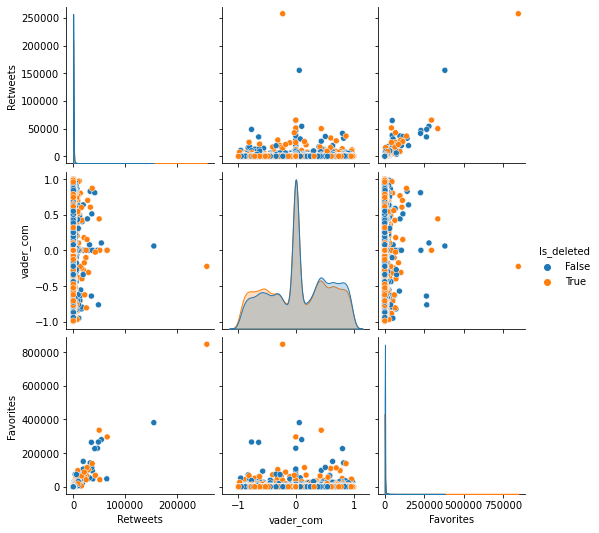

In [6]:
df = df_tweetscov19_user[['Is_deleted', 'Retweets', 'vader_com', 'Favorites']]
plot_paiplot(df, 'Is_deleted', 'pairplot_tweetsocv19_Retweet_favoriet_sentiment')

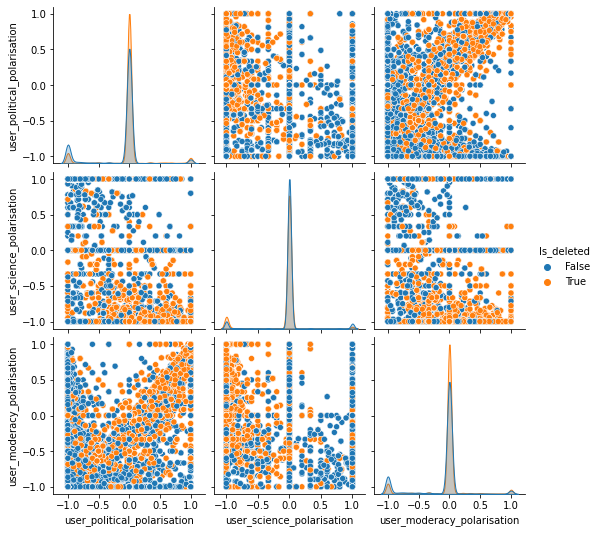

In [7]:
df = df_tweetscov19_user[['Is_deleted', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation']]
plot_paiplot(df, 'Is_deleted', 'pairplot_tweetsocv19_politic_science_moderacy')

In [5]:
features = df_tweetscov19_user.columns
features

Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg',
       'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num',
       'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent',
       'tweet_politic_polarisation', 'tweet_science_polarisation',
       'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female',
       'male', 'work', 'leisure', 'home', 'money', 'relegion', 'death',
       'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body',
       'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad',
       'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ',
       'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they',
       'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate',
       'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear',
       'feel', 'motion', 'space', 'tim

In [6]:
df_tweetscov19_user['Is_deleted'] = np.where(df_tweetscov19_user['Is_deleted'] == True, 1, 0)

In [7]:
df_tweetscov19_user.tail()

Tweet_Id                          Username  Retweets  \
199995  1259248202936655875  eab957491d944a82619078d0e7abde35        18   
199996  1243117743253184512  9b6d1d0aa2acc32b83aba7ff58a06f5f         0   
199997  1242179037067235328  d35257c8e79ae63103199097924f9c3e         0   
199998  1259082154258108417  e0cfe6df4c21b3e806fdf8c82f71cc9b         1   
199999  1194973563201228801  475e95f426531b34d03436b841566b89         0   

        Favorites  Vader_neg  Vader_neu  Vader_pos  vader_com  Hashtags_num  \
199995         34    -0.1360     0.7460     0.1180     0.0516             0   
199996          0    -0.0000     0.7310     0.2690     0.8286             0   
199997          0    -0.0000     0.9260     0.0740     0.4019             1   
199998          0    -0.2060     0.7940     0.0000    -0.5994             0   
199999          0    -0.0000     0.8520     0.1480     0.5719             0   

        Mentions_num  Text_len  URLs_num  readability  Emoji_num  Emoji_sent  \
199995             1       244         1      68.2150          0      0.0000   
199996             0       136         0      86.7050          0      0.0000   
199997             0       223         0      76.9710          0      0.0000   
199998             0        98         0      99.0890          2      0.2000   
199999             1       165         0      87.2700          0      0.0000   

        tweet_politic_polarisation  tweet_science_polarisation  \
199995                      0.0000                      0.0000   
199996                      0.0000                      0.0000   
199997                      0.0000                      0.0000   
199998                      0.0000                      0.0000   
199999                      0.0000                      0.0000   

        tweet_moderacy_polarisation  social  family  friend  female   male  \
199995                       0.0000 11.6300  0.0000  0.0000  0.0000 6.9800   
199996                       0.0000  7.1400  0.0000  0.0000  0.0000 0.0000   
199997                       0.0000  7.5000  0.0000  0.0000  0.0000 7.5000   
199998                       0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
199999                       0.0000  6.6700  0.0000  0.0000  0.0000 0.0000   

         work  leisure   home  money  relegion  death  informal  swear  \
199995 2.3300   0.0000 0.0000 0.0000    0.0000 2.3300    0.0000 0.0000   
199996 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000   
199997 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000   
199998 0.0000   0.0000 0.0000 0.0000    0.0000 6.2500    0.0000 0.0000   
199999 3.3300   0.0000 0.0000 3.3300    0.0000 0.0000    0.0000 0.0000   

        netspeak  assent  nonflu  filler   body  health  sexual  ingest  \
199995    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000   
199996    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000   
199997    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000   
199998    0.0000  0.0000  0.0000  0.0000 0.0000  6.2500  0.0000  0.0000   
199999    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000   

        posemo  negemo    anx  anger    sad  insight  cause  discrep  tentat  \
199995  2.3300  4.6500 0.0000 4.6500 0.0000   2.3300 0.0000   0.0000  0.0000   
199996  3.5700  0.0000 0.0000 0.0000 0.0000   0.0000 0.0000   0.0000  0.0000   
199997  0.0000  0.0000 0.0000 0.0000 0.0000   0.0000 2.5000   0.0000  0.0000   
199998  0.0000  0.0000 0.0000 0.0000 0.0000   0.0000 0.0000   0.0000  6.2500   
199999  0.0000  0.0000 0.0000 0.0000 0.0000   3.3300 0.0000   0.0000  6.6700   

        certain  differ  affiliation  achiev  power  reward   risk  focuspast  \
199995   0.0000  4.6500       0.0000  4.6500 4.6500  4.6500 0.0000     2.3300   
199996   0.0000  0.0000       3.5700  0.0000 0.0000  3.5700 0.0000     0.0000   
199997   2.5000  2.5000       0.0000  0.0000 0.0000  0.0000 0.0000     2.5000   
199998   0.0000  6.2500       0.0000  0.0000 

In [8]:
#df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'Tweet_Id', 'Username', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio'])

In [3]:
def get_X_y(df, features):
    
    if 'Is_deleted' not in features:
        features = np.append(features, 'Is_deleted')
        
    df = df[features.tolist()]
    X = df.drop('Is_deleted', axis=1)
    y = df['Is_deleted']

    y = y.astype(int)
    print(X.shape)
    print(y.shape)
    
    return X,y

In [10]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(200000, 89)
(200000,)


In [4]:
def split_train_test_valid(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=15)
    #X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=15)
    print(X_train.shape)
    print(X_test.shape)
    #print(X_valid.shape)

    print(y_train.shape)
    print(y_test.shape)
    #print(y_valid.shape)
    return  X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 89)
(40000, 89)
(160000,)
(40000,)


In [5]:
def fit_log_reg(X,y):
    l_regression = LogisticRegression(random_state=20, solver = 'lbfgs')
    l_regression.fit(X,y)
    return l_regression

In [6]:
def test_log_reg(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('Accuracy :', accuracy_score(y_test, y_pred))
    

In [15]:
l_regression = fit_log_reg(X_train, y_train)

In [16]:
test_log_reg(l_regression, X_test,y_test)

Accuracy : 0.5712


In [17]:
y_pred = l_regression.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.67      0.61     20090
           1       0.59      0.47      0.52     19910

    accuracy                           0.57     40000
   macro avg       0.57      0.57      0.57     40000
weighted avg       0.57      0.57      0.57     40000



In [7]:
def plot_confusion_matrix(confu_matrix, classes, titel):
    sns.heatmap(confu_matrix, xticklabels = classes, yticklabels = classes, annot=True)
    plt.title(titel)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[0.66953708 0.33046292]
 [0.52802612 0.47197388]]


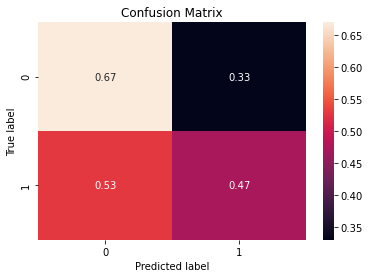

In [19]:
confusion_mx = confusion_matrix(y_test, y_pred)
confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(confusion_mx, l_regression.classes_, 'Confusion Matrix')
print(confusion_mx)

In [8]:
def print_cross_val_score(model, X, y):
    scores = cross_val_score(model, X, y, cv=10, scoring='precision')
    print(" percision : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='f1')
    print(" f1        : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='recall')
    print(" recall    : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

In [21]:
clf_cv = LogisticRegression(random_state=20, solver = 'lbfgs')
print_cross_val_score(clf_cv, X, y)

 percision : 0.58 +/- 0.007
 f1        : 0.53 +/- 0.011
 recall    : 0.50 +/- 0.016


***

In [22]:
#Finding best DecisionTreeClassifier for detecting feature importances
param_grid = {'criterion':['gini','entropy'],
              'max_depth': range(1,10),
              'random_state' : [5, 10, 15],
              'min_samples_split' : range(1,10),
              'min_samples_leaf' : range(1,10)}

In [23]:
model = DecisionTreeClassifier()

DecisionTreeClassifier_clf = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [24]:
%%time
best_clf = DecisionTreeClassifier_clf.fit(X_train,y_train)

Fitting 5 folds for each of 4374 candidates, totalling 21870 fits
Wall time: 9min 3s


In [25]:
best_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'random_state': 5}

****

In [22]:
def features_classifier_tweetscov19(X, y):

    decisionTC = DecisionTreeClassifier(random_state=5, criterion= 'entropy', max_depth = 6, min_samples_leaf= 3, min_samples_split= 2 )
    decisionTC.fit(X,y)
    
    column_feature = {}

    for i, c in enumerate(X):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = decisionTC.feature_importances_[i]
        
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)
    
    return df_column_feature.reset_index()

In [23]:
f_importances = features_classifier_tweetscov19( X, y)
f_importances

index                                  Feature  importance
0      83                          user_Reputation      0.4091
1      81                user_science_polarisation      0.1637
2       9                                 URLs_num      0.1303
3      82               user_moderacy_polarisation      0.0973
4      80              user_political_polarisation      0.0499
5       6                             Hashtags_num      0.0372
6       8                                 Text_len      0.0286
7      84               user_vadercompound_average      0.0253
8      27                                 informal      0.0193
9      56                                        i      0.0134
10     86  tweet_political_polarisation_abweichung      0.0115
11     11                                Emoji_num      0.0065
12      1                                Favorites      0.0034
13      7                             Mentions_num      0.0012
14     68                                     verb      0.0009
15     21                                     work      0.0007
16     85           tweet_vadercompound_abweichung      0.0006
17     55                              focusfuture      0.0004
18      5                                vader_com      0.0004
19     10                              readability      0.0004
20     63                                     prep      0.0000
21     62                                  article      0.0000
22     61                                    ipron      0.0000
23     59                                    shehe      0.0000
24     60                                     they      0.0000
25      0                                 Retweets      0.0000
26     58                                      you      0.0000
27     57                                       we      0.0000
28     54                             focuspresent      0.0000
29     53                                focuspast      0.0000
30     65                                   adverb      0.0000
31     52                                     risk      0.0000
32     64                                  auxverb      0.0000
33     73                                    quant      0.0000
34     66                                     conj      0.0000
35     67                                   negate      0.0000
36     69                                      adj      0.0000
37     70                                  compare      0.0000
38     71                                 interrog      0.0000
39     72                                   number      0.0000
40     50                                    power      0.0000
41     74                                      see      0.0000
42     75                                     hear      0.0000
43     76                                     feel      0.0000
44     77                                   motion      0.0000
45     78                                    space      0.0000
46     79                                     time      0.0000
47     87    tweet_science_polarisation_abweichung      0.0000
48     51                                   reward      0.0000
49     44                                  discrep      0.0000
50     49                                   achiev      0.0000
51     17                                   family      0.0000
52     25                                 relegion      0.0000
53     24                                    money      0.0000
54     23                                     home      0.0000
55     22                                  leisure      0.0000
56     20                                     male      0.0000
57     19                                   female      0.0000
58     18                                   friend      0.0000
59     16                                   social      0.0000
60     28                                    swear      0.0000
61     15              tweet_moderacy_polarisation      0.0000
62     14               tweet_scien

In [24]:
f_importances = f_importances[f_importances['importance'] != 0.0]
f_importances = f_importances.Feature.values
print(f_importances)

['user_Reputation' 'user_science_polarisation' 'URLs_num'
 'user_moderacy_polarisation' 'user_political_polarisation' 'Hashtags_num'
 'Text_len' 'user_vadercompound_average' 'informal' 'i'
 'tweet_political_polarisation_abweichung' 'Emoji_num' 'Favorites'
 'Mentions_num' 'verb' 'work' 'tweet_vadercompound_abweichung'
 'focusfuture' 'vader_com' 'readability']


In [25]:
len(f_importances)

20

In [26]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(200000, 20)
(200000,)


***

In [32]:
param_grid = [{'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             {'C' : np.logspace(-4,4,20)},
             {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'ag', 'saga']},
             {'max_iter' : [100, 200, 500, 1000, 2500, 5000]}]

In [33]:
l_regression_GridS = LogisticRegression()

clf = GridSearchCV(l_regression_GridS, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [34]:
%%time
best_clf = clf.fit(X_train,y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Wall time: 1min 4s


In [35]:
best_clf.best_estimator_

LogisticRegression(max_iter=2500)

In [36]:
best_clf.best_params_

{'max_iter': 2500}

In [27]:
l_regression_best = LogisticRegression(max_iter=2500)

print_cross_val_score(l_regression_best, X_new, y)

 percision : 0.59 +/- 0.005
 f1        : 0.62 +/- 0.004
 recall    : 0.64 +/- 0.005


In [28]:
l_regression_best = LogisticRegression(max_iter=2500)

print_cross_val_score(l_regression_best, X, y)

 percision : 0.60 +/- 0.004
 f1        : 0.61 +/- 0.005
 recall    : 0.63 +/- 0.008


****************************************************************************
****************************************************************************

### Tweetscov19
#### (Conten only)

In [29]:
features = df_tweetscov19_user.columns
features

#features = features[2:83]
df_tweetscov19_user = df_tweetscov19_user[features.tolist()]
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_vadercompound_average', 'tweet_vadercompound_abweichung', 'tweet_political_polarisation_abweichung', 'tweet_science_polarisation_abweichung', 'tweet_moderacy_polarisation_abweichung' ])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation'])


In [30]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(200000, 80)
(200000,)


In [31]:
f_importances = features_classifier_tweetscov19( X, y)
f_importances

index                      Feature  importance
0       9                     URLs_num      0.2650
1       0                     Retweets      0.1530
2      14   tweet_science_polarisation      0.1086
3      21                         work      0.0737
4       6                 Hashtags_num      0.0707
5      13   tweet_politic_polarisation      0.0612
6       8                     Text_len      0.0513
7      15  tweet_moderacy_polarisation      0.0311
8       1                    Favorites      0.0264
9       7                 Mentions_num      0.0211
10     10                  readability      0.0185
11     56                            i      0.0181
12     27                     informal      0.0169
13     40                        anger      0.0130
14     11                    Emoji_num      0.0118
15     63                         prep      0.0105
16     28                        swear      0.0100
17      2                    Vader_neg      0.0091
18     35                       sexual      0.0076
19     62                      article      0.0040
20     54                 focuspresent      0.0029
21     23                         home      0.0027
22     45                       tentat      0.0019
23     79                         time      0.0019
24     31                       nonflu      0.0018
25     78                        space      0.0018
26     58                          you      0.0017
27     48                  affiliation      0.0017
28     68                         verb      0.0010
29     61                        ipron      0.0006
30     53                    focuspast      0.0000
31     59                        shehe      0.0000
32     60                         they      0.0000
33     57                           we      0.0000
34     55                  focusfuture      0.0000
35     65                       adverb      0.0000
36     64                      auxverb      0.0000
37     51                       reward      0.0000
38     66                         conj      0.0000
39     67                       negate      0.0000
40     69                          adj      0.0000
41     70                      compare      0.0000
42     71                     interrog      0.0000
43     72                       number      0.0000
44     73                        quant      0.0000
45     74                          see      0.0000
46     75                         hear      0.0000
47     76                         feel      0.0000
48     77                       motion      0.0000
49     52                         risk      0.0000
50     12                   Emoji_sent      0.0000
51     50                        power      0.0000
52     30                       assent      0.0000
53     16                       social      0.0000
54     17                       family      0.0000
55     18                       friend      0.0000
56     19                       female      0.0000
57     20                         male      0.0000
58      5                    vader_com      0.0000
59     22                      leisure      0.0000
60     24                        money      0.0000
61     25                     relegion      0.0000
62     26                        death      0.0000
63      4                    Vader_pos      0.0000
64     29                     netspeak      0.0000
65     32                       filler      0.0000
66     49                       achiev      0.0000
67     33                         body      0.0000
68     34                       health      0.0000
69     36                       ingest      0.0000
70     37                       posemo      0.0000
71     38                       negemo      0.0000
72     39                          anx      0.0000
73      3                    Vader_neu      0.0000
74     41                          sad      0.0000
75     42                      insight      0.0000
76     43                        cause      0.0000
77     44                 

In [32]:
f_importances = f_importances[f_importances['importance'] != 0.00]
f_importances = f_importances.Feature.values

print(len(f_importances))
print(f_importances)

30
['URLs_num' 'Retweets' 'tweet_science_polarisation' 'work' 'Hashtags_num'
 'tweet_politic_polarisation' 'Text_len' 'tweet_moderacy_polarisation'
 'Favorites' 'Mentions_num' 'readability' 'i' 'informal' 'anger'
 'Emoji_num' 'prep' 'swear' 'Vader_neg' 'sexual' 'article' 'focuspresent'
 'home' 'tentat' 'time' 'nonflu' 'space' 'you' 'affiliation' 'verb'
 'ipron']


In [33]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(200000, 30)
(200000,)


In [34]:
l_regression_best = LogisticRegression(max_iter=2500)

print_cross_val_score(l_regression_best, X_new, y)

 percision : 0.58 +/- 0.005
 f1        : 0.60 +/- 0.006
 recall    : 0.62 +/- 0.014


In [35]:
l_regression_best = LogisticRegression(max_iter=2500)

print_cross_val_score(l_regression_best, X, y)

 percision : 0.58 +/- 0.005
 f1        : 0.59 +/- 0.007
 recall    : 0.60 +/- 0.010


****************************************************************
****************************************************************

## *(2)Tweetskb*
### (Content + User feature)

In [9]:
path = '../data/df_tweetskb_sample_200000.tsv'

df_tweetskb_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg', 'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num', 'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent', 'tweet_politic_polarisation', 'tweet_science_polarisation', 'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female', 'male' , 'work', 'leisure', 'home', 'money', 'relegion', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body', 'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear', 'feel', 'motion', 'space', 'time', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation', 'Is_deleted', 'user_vadercompound_average', 'tweet_vadercompound_abweichung', 'tweet_political_polarisation_abweichung', 'tweet_science_polarisation_abweichung', 'tweet_moderacy_polarisation_abweichung' ])

print('Shape :', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape : (200000, 95)


Tweet_Id        Username  Retweets  Favorites  Vader_neg  \
0  1183735622982344705  ScandalofSpeed         2         10    -0.0790   
1  1219313839151423495       pwns4cash         0          0    -0.0000   
2  1188314245760311296  MadMax26125746         0          0    -0.2680   
3  1199082882238537729     kirstenigot         0          0    -0.0000   
4  1209565509068500992        pie_yann         0          0    -0.6940   

   Vader_neu  Vader_pos  vader_com  Hashtags_num  Mentions_num  Text_len  \
0     0.8860     0.0350    -0.3382             0             0       187   
1     0.7060     0.2940     0.3612             0             1        41   
2     0.7320     0.0000    -0.5106             0             1        63   
3     0.7410     0.2590     0.6739             2             0       105   
4     0.3060     0.0000    -0.7783             0             2        34   

   URLs_num  readability  Emoji_num  Emoji_sent  tweet_politic_polarisation  \
0         0      60.1090          0      0.0000                      0.0000   
1         0      78.8730          0      0.0000                      0.0000   
2         0      52.8650          0      0.0000                      0.0000   
3         1      53.6390          0      0.0000                      0.0000   
4         0      66.4000          0      0.0000                      0.0000   

   tweet_science_polarisation  tweet_moderacy_polarisation  social  family  \
0                      0.0000                       0.0000  3.4500  0.0000   
1                      0.0000                       0.0000  0.0000  0.0000   
2                      0.0000                       0.0000  9.0900  0.0000   
3                      0.0000                       0.0000  0.0000  0.0000   
4                      0.0000                       0.0000  0.0000  0.0000   

   friend  female   male   work  leisure   home  money  relegion  death  \
0  0.0000  3.4500 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
1  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
2  0.0000  0.0000 9.0900 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
3  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
4  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   

   informal   swear  netspeak  assent  nonflu  filler    body  health  sexual  \
0    0.0000  0.0000    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1    0.0000  0.0000    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2    0.0000  0.0000    0.0000  0.0000  0.0000  0.0000  0.0000  9.0900  0.0000   
3    0.0000  0.0000    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
4   40.0000 40.0000    0.0000  0.0000  0.0000  0.0000 20.0000  0.0000  0.0000   

   ingest  posemo  negemo    anx   anger    sad  insight  cause  discrep  \
0  0.0000  0.0000  0.0000 0.0000  0.0000 0.0000   3.4500 3.4500   0.0000   
1  0.0000  0.0000  0.0000 0.0000  0.0000 0.0000   0.0000 0.0000   0.0000   
2  0.0000  0.0000  9.0900 0.0000  9.0900 0.0000   0.0000 0.0000   0.0000   
3  0.0000  0.0000  0.0000 0.0000  0.0000 0.0000   0.0000 0.0000   0.0000   
4  0.0000  0.0000 20.0000 0.0000 20.0000 0.0000   0.0000 0.0000   0.0000   

   tentat  certain  differ  affiliation  achiev  power  reward   risk  \
0  3.4500   6.9000  0.0000       0.0000  0.0000 3.4500  0.0000 0.0000   
1  0.0000   0.0000  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000   
2  0.0000   0.0000  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000   
3  0.0000   0.0000  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000   
4  0.0000   0.0000  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000   

   focuspast  focuspresent  focusfuture      i     we    you  shehe   they  \
0    10.3400        0.0000       0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
1     0.0000        0.0000       0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
2    18.1800        0.0000       0.0000 0.0000 0.0000 9.0900 0.0000 0.0000   
3     0.0000        0.

In [10]:
df_tweetskb_user = df_tweetskb_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape:  (200000, 95)


Tweet_Id        Username  Retweets  Favorites  Vader_neg  \
0  1251928539567456258      Froskurinn        55       1088    -0.0730   
1  1253683459282874370  TheBlondePerry         0          0    -0.0000   
2  1254291620784037893     sweettteeth         0          0    -0.0000   
3  1245174281815769089       haniexied         0          0    -0.3840   
4  1249356812413009921       anaaabis_         0          0    -0.1110   

   Vader_neu  Vader_pos  vader_com  Hashtags_num  Mentions_num  Text_len  \
0     0.9270     0.0000    -0.1280             0             0       107   
1     0.7200     0.2800     0.8122             0             1       134   
2     0.0780     0.9220     0.9712             0             0        51   
3     0.4410     0.1740    -0.5154             0             1        35   
4     0.4690     0.4190     0.9100             0             0        71   

   URLs_num  readability  Emoji_num  Emoji_sent  tweet_politic_polarisation  \
0         0      99.4100          0      0.0000                      0.0000   
1         0      85.0270          0      0.0000                      0.0000   
2         0      78.2450          0      0.0000                      0.0000   
3         0     103.0440          1     -0.0930                      0.0000   
4         0      72.6150          3      0.2210                      0.0000   

   tweet_science_polarisation  tweet_moderacy_polarisation  social  family  \
0                      0.0000                       0.0000  9.5200  0.0000   
1                      0.0000                       0.0000 12.5000  0.0000   
2                      0.0000                       0.0000  0.0000  0.0000   
3                      0.0000                       0.0000 14.2900  0.0000   
4                      0.0000                       0.0000 23.0800  0.0000   

   friend  female   male   work  leisure   home  money  relegion  death  \
0  0.0000  0.0000 0.0000 4.7600   0.0000 0.0000 0.0000    0.0000 0.0000   
1  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
2  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
3  0.0000 14.2900 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
4  7.6900  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   

   informal   swear  netspeak  assent  nonflu  filler   body  health  sexual  \
0    0.0000  0.0000    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000   
1    0.0000  0.0000    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000   
2   40.0000  0.0000    0.0000 40.0000  0.0000  0.0000 0.0000  0.0000  0.0000   
3   14.2900 14.2900    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000   
4    0.0000  0.0000    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000   

   ingest  posemo  negemo    anx   anger    sad  insight  cause  discrep  \
0  0.0000  0.0000  4.7600 0.0000  4.7600 0.0000   0.0000 0.0000   0.0000   
1  0.0000  4.1700  0.0000 0.0000  0.0000 0.0000   0.0000 0.0000   4.1700   
2  0.0000  0.0000  0.0000 0.0000  0.0000 0.0000   0.0000 0.0000   0.0000   
3  0.0000  0.0000 14.2900 0.0000 14.2900 0.0000   0.0000 0.0000   0.0000   
4  0.0000 15.3800  0.0000 0.0000  0.0000 0.0000   0.0000 0.0000   0.0000   

   tentat  certain  differ  affiliation  achiev  power  reward   risk  \
0  0.0000   4.7600  4.7600       4.7600  9.5200 9.5200  0.0000 0.0000   
1  0.0000   4.1700  0.0000       4.1700  4.1700 4.1700  4.1700 0.0000   
2  0.0000   0.0000  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000   
3  0.0000   0.0000  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000   
4  0.0000   0.0000  0.0000       7.6900  0.0000 0.0000  0.0000 0.0000   

   focuspast  focuspresent  focusfuture      i     we     you  shehe   they  \
0     9.5200        0.0000       0.0000 4.7600 0.0000  0.0000 4.7600 0.0000   
1    16.6700        0.0000       0.0000 4.1700 0.0000  0.0000 0.0000 0.0000   
2     0.0000        0.0000       0.0000 0.0000 0.0000  0.0000 0.0000 0.0000   
3     0.0000        0.00

In [11]:
df_tweetskb_user.Username.unique().size

186572

In [12]:
df_tweetskb_del = df_tweetskb_user[df_tweetskb_user['Is_deleted']==True]
df_tweetskb_undel = df_tweetskb_user[df_tweetskb_user['Is_deleted']==False]

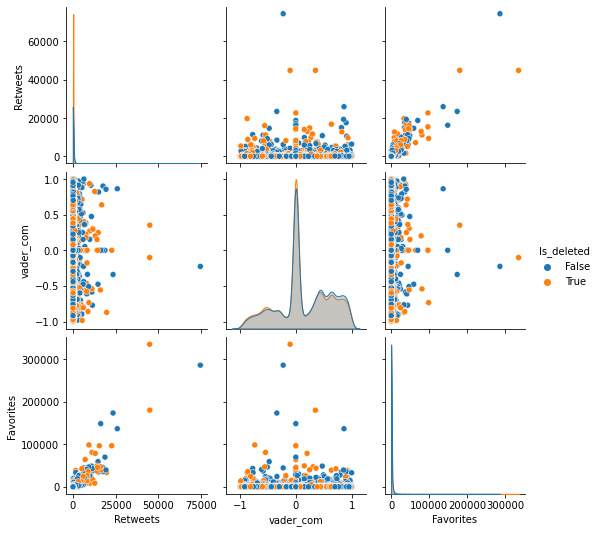

In [13]:
df = df_tweetskb_user[['Is_deleted', 'Retweets', 'vader_com', 'Favorites']]
plot_paiplot(df, 'Is_deleted', 'pairplot_tweetskb_Retweet_favoriet_sentiment')

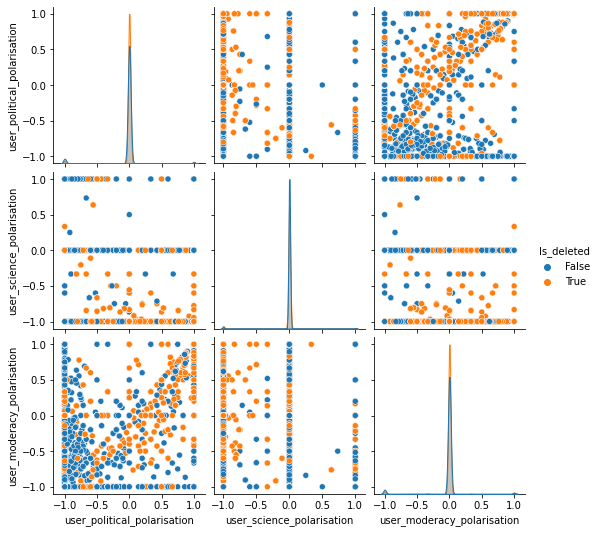

In [14]:
df = df_tweetskb_user[['Is_deleted',  'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation']]
plot_paiplot(df, 'Is_deleted', 'pairplot_tweetskb_politic_science_moderacy')

In [15]:
features = df_tweetskb_user.columns
features

Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg',
       'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num',
       'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent',
       'tweet_politic_polarisation', 'tweet_science_polarisation',
       'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female',
       'male', 'work', 'leisure', 'home', 'money', 'relegion', 'death',
       'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body',
       'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad',
       'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ',
       'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they',
       'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate',
       'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear',
       'feel', 'motion', 'space', 'tim

In [16]:
df_tweetskb_user['Is_deleted'] = np.where(df_tweetskb_user['Is_deleted'] == True, 1, 0)
df_tweetskb_user.head()

Tweet_Id        Username  Retweets  Favorites  Vader_neg  \
0  1251928539567456258      Froskurinn        55       1088    -0.0730   
1  1253683459282874370  TheBlondePerry         0          0    -0.0000   
2  1254291620784037893     sweettteeth         0          0    -0.0000   
3  1245174281815769089       haniexied         0          0    -0.3840   
4  1249356812413009921       anaaabis_         0          0    -0.1110   

   Vader_neu  Vader_pos  vader_com  Hashtags_num  Mentions_num  Text_len  \
0     0.9270     0.0000    -0.1280             0             0       107   
1     0.7200     0.2800     0.8122             0             1       134   
2     0.0780     0.9220     0.9712             0             0        51   
3     0.4410     0.1740    -0.5154             0             1        35   
4     0.4690     0.4190     0.9100             0             0        71   

   URLs_num  readability  Emoji_num  Emoji_sent  tweet_politic_polarisation  \
0         0      99.4100          0      0.0000                      0.0000   
1         0      85.0270          0      0.0000                      0.0000   
2         0      78.2450          0      0.0000                      0.0000   
3         0     103.0440          1     -0.0930                      0.0000   
4         0      72.6150          3      0.2210                      0.0000   

   tweet_science_polarisation  tweet_moderacy_polarisation  social  family  \
0                      0.0000                       0.0000  9.5200  0.0000   
1                      0.0000                       0.0000 12.5000  0.0000   
2                      0.0000                       0.0000  0.0000  0.0000   
3                      0.0000                       0.0000 14.2900  0.0000   
4                      0.0000                       0.0000 23.0800  0.0000   

   friend  female   male   work  leisure   home  money  relegion  death  \
0  0.0000  0.0000 0.0000 4.7600   0.0000 0.0000 0.0000    0.0000 0.0000   
1  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
2  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
3  0.0000 14.2900 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
4  7.6900  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   

   informal   swear  netspeak  assent  nonflu  filler   body  health  sexual  \
0    0.0000  0.0000    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000   
1    0.0000  0.0000    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000   
2   40.0000  0.0000    0.0000 40.0000  0.0000  0.0000 0.0000  0.0000  0.0000   
3   14.2900 14.2900    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000   
4    0.0000  0.0000    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000   

   ingest  posemo  negemo    anx   anger    sad  insight  cause  discrep  \
0  0.0000  0.0000  4.7600 0.0000  4.7600 0.0000   0.0000 0.0000   0.0000   
1  0.0000  4.1700  0.0000 0.0000  0.0000 0.0000   0.0000 0.0000   4.1700   
2  0.0000  0.0000  0.0000 0.0000  0.0000 0.0000   0.0000 0.0000   0.0000   
3  0.0000  0.0000 14.2900 0.0000 14.2900 0.0000   0.0000 0.0000   0.0000   
4  0.0000 15.3800  0.0000 0.0000  0.0000 0.0000   0.0000 0.0000   0.0000   

   tentat  certain  differ  affiliation  achiev  power  reward   risk  \
0  0.0000   4.7600  4.7600       4.7600  9.5200 9.5200  0.0000 0.0000   
1  0.0000   4.1700  0.0000       4.1700  4.1700 4.1700  4.1700 0.0000   
2  0.0000   0.0000  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000   
3  0.0000   0.0000  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000   
4  0.0000   0.0000  0.0000       7.6900  0.0000 0.0000  0.0000 0.0000   

   focuspast  focuspresent  focusfuture      i     we     you  shehe   they  \
0     9.5200        0.0000       0.0000 4.7600 0.0000  0.0000 4.7600 0.0000   
1    16.6700        0.0000       0.0000 4.1700 0.0000  0.0000 0.0000 0.0000   
2     0.0000        0.0000       0.0000 0.0000 0.0000  0.0000 0.0000 0.0000   
3     0.0000        0.00

In [17]:
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'Tweet_Id', 'Username', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio'])

In [18]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 89)
(200000,)


In [19]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 89)
(40000, 89)
(160000,)
(40000,)


***

In [22]:
#Finding best DecisionTreeClassifier for detecting the feature importances
param_grid = {'criterion':['gini','entropy'],
              'max_depth': range(1,10),
              'random_state' : [5, 10, 15],
              'min_samples_split' : range(1,10),
              'min_samples_leaf' : range(1,10)}

In [23]:
model = DecisionTreeClassifier()

DecisionTreeClassifier_clf = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [24]:
%%time
best_clf = DecisionTreeClassifier_clf.fit(X_train,y_train)

Fitting 5 folds for each of 4374 candidates, totalling 21870 fits
Wall time: 7min 32s


In [25]:
best_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'random_state': 15}

In [20]:
def features_classifier_tweetskb(X, y):

    decisionTC = DecisionTreeClassifier(random_state=5, criterion= 'entropy', max_depth = 8, min_samples_leaf=7, min_samples_split=2)
    decisionTC.fit(X,y)
    
    column_feature = {}

    for i, c in enumerate(X):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = decisionTC.feature_importances_[i]
        
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)
    
    return df_column_feature.reset_index()

In [21]:
features_cl = features_classifier_tweetskb( X, y)
features_cl

index                                  Feature  importance
0      83                          user_Reputation      0.1834
1       9                                 URLs_num      0.1026
2      62                                  article      0.0972
3      55                              focusfuture      0.0769
4      27                                 informal      0.0746
5      81                user_science_polarisation      0.0735
6      84               user_vadercompound_average      0.0514
7      80              user_political_polarisation      0.0419
8       7                             Mentions_num      0.0288
9       8                                 Text_len      0.0260
10      6                             Hashtags_num      0.0252
11     35                                   sexual      0.0248
12     10                              readability      0.0133
13      0                                 Retweets      0.0127
14     21                                     work      0.0091
15     12                               Emoji_sent      0.0090
16     11                                Emoji_num      0.0084
17     82               user_moderacy_polarisation      0.0076
18     87    tweet_science_polarisation_abweichung      0.0075
19      3                                Vader_neu      0.0074
20     53                                focuspast      0.0072
21     16                                   social      0.0071
22     29                                 netspeak      0.0070
23     85           tweet_vadercompound_abweichung      0.0069
24     67                                   negate      0.0059
25      1                                Favorites      0.0054
26      5                                vader_com      0.0052
27     64                                  auxverb      0.0044
28     50                                    power      0.0043
29     61                                    ipron      0.0040
30     45                                   tentat      0.0040
31     44                                  discrep      0.0038
32     74                                      see      0.0035
33     77                                   motion      0.0032
34     48                              affiliation      0.0032
35     76                                     feel      0.0031
36     30                                   assent      0.0030
37     22                                  leisure      0.0029
38     20                                     male      0.0027
39     38                                   negemo      0.0027
40     40                                    anger      0.0025
41     60                                     they      0.0023
42     65                                   adverb      0.0020
43     28                                    swear      0.0019
44     49                                   achiev      0.0018
45     33                                     body      0.0017
46     68                                     verb      0.0015
47      4                                Vader_pos      0.0015
48     72                                   number      0.0014
49     34                                   health      0.0014
50     78                                    space      0.0013
51     70                                  compare      0.0013
52     26                                    death      0.0012
53     66                                     conj      0.0011
54     63                                     prep      0.0010
55     32                                   filler      0.0010
56     51                                   reward      0.0009
57     57                                       we      0.0009
58     43                                    cause      0.0009
59     54                             focuspresent      0.0008
60     73                                    quant      0.0006
61     17                                   family      0.0000
62     37                          

In [22]:
features_cl = features_cl[features_cl['importance'] != 0.0]
features_cl = features_cl.Feature.values
print(features_cl)

['user_Reputation' 'URLs_num' 'article' 'focusfuture' 'informal'
 'user_science_polarisation' 'user_vadercompound_average'
 'user_political_polarisation' 'Mentions_num' 'Text_len' 'Hashtags_num'
 'sexual' 'readability' 'Retweets' 'work' 'Emoji_sent' 'Emoji_num'
 'user_moderacy_polarisation' 'tweet_science_polarisation_abweichung'
 'Vader_neu' 'focuspast' 'social' 'netspeak'
 'tweet_vadercompound_abweichung' 'negate' 'Favorites' 'vader_com'
 'auxverb' 'power' 'ipron' 'tentat' 'discrep' 'see' 'motion' 'affiliation'
 'feel' 'assent' 'leisure' 'male' 'negemo' 'anger' 'they' 'adverb' 'swear'
 'achiev' 'body' 'verb' 'Vader_pos' 'number' 'health' 'space' 'compare'
 'death' 'conj' 'prep' 'filler' 'reward' 'we' 'cause' 'focuspresent'
 'quant']


In [23]:
X_new,y = get_X_y(df_tweetskb_user, features_cl)

(200000, 61)
(200000,)


In [25]:
param_grid = [{'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             {'C' : np.logspace(-4,4,20)},
             {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'ag', 'saga']},
             {'max_iter' : [100, 200, 500, 1000, 2500, 5000]}]

In [26]:
l_regression_GridS = LogisticRegression()

best_clf = GridSearchCV(l_regression_GridS, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)

In [27]:
%%time
best_clf = best_clf.fit(X_train,y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Wall time: 12min 45s


In [28]:
best_clf.best_estimator_

LogisticRegression(max_iter=2500)

In [29]:
best_clf.best_params_

{'max_iter': 2500}

In [30]:
l_regression_best = LogisticRegression(max_iter=2500)

print_cross_val_score(l_regression_best, X_new, y)

 percision : 0.56 +/- 0.002
 f1        : 0.56 +/- 0.003
 recall    : 0.57 +/- 0.006


In [31]:
l_regression_best = LogisticRegression(max_iter=2500)

print_cross_val_score(l_regression_best, X, y)

 percision : 0.56 +/- 0.001
 f1        : 0.56 +/- 0.004
 recall    : 0.57 +/- 0.008


**********************************************************************
**********************************************************************

### Tweetskb
#### (Content only)

In [32]:
features = df_tweetskb_user.columns
features

#features = features[2:83]
df_tweetskb_user = df_tweetskb_user[features.tolist()]
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_vadercompound_average', 'tweet_vadercompound_abweichung', 'tweet_political_polarisation_abweichung', 'tweet_science_polarisation_abweichung', 'tweet_moderacy_polarisation_abweichung' ])
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation'])


In [33]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 80)
(200000,)


In [34]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 80)
(40000, 80)
(160000,)
(40000,)


In [38]:
f_importances = features_classifier_tweetskb( X, y)
f_importances

index                      Feature  importance
0      62                      article      0.1318
1       9                     URLs_num      0.1303
2      55                  focusfuture      0.0982
3      27                     informal      0.0871
4       6                 Hashtags_num      0.0623
5      21                         work      0.0468
6       7                 Mentions_num      0.0466
7      35                       sexual      0.0400
8      14   tweet_science_polarisation      0.0293
9       0                     Retweets      0.0281
10      8                     Text_len      0.0276
11      4                    Vader_pos      0.0211
12     11                    Emoji_num      0.0183
13     10                  readability      0.0174
14     16                       social      0.0173
15     12                   Emoji_sent      0.0156
16      5                    vader_com      0.0142
17     13   tweet_politic_polarisation      0.0122
18     78                        space      0.0111
19     29                     netspeak      0.0091
20      2                    Vader_neg      0.0087
21     53                    focuspast      0.0080
22      1                    Favorites      0.0072
23     40                        anger      0.0067
24      3                    Vader_neu      0.0058
25     22                      leisure      0.0056
26     50                        power      0.0052
27     60                         they      0.0051
28     77                       motion      0.0051
29     44                      discrep      0.0050
30     19                       female      0.0050
31     67                       negate      0.0045
32     42                      insight      0.0042
33     64                      auxverb      0.0038
34     30                       assent      0.0038
35     33                         body      0.0037
36     57                           we      0.0035
37     46                      certain      0.0033
38     37                       posemo      0.0032
39     52                         risk      0.0031
40     48                  affiliation      0.0028
41     20                         male      0.0026
42     70                      compare      0.0024
43     28                        swear      0.0024
44     24                        money      0.0023
45     36                       ingest      0.0023
46     23                         home      0.0023
47     63                         prep      0.0023
48     15  tweet_moderacy_polarisation      0.0020
49     65                       adverb      0.0020
50     17                       family      0.0019
51     31                       nonflu      0.0017
52     43                        cause      0.0015
53     38                       negemo      0.0015
54     49                       achiev      0.0014
55     66                         conj      0.0013
56     76                         feel      0.0013
57     41                          sad      0.0012
58     32                       filler      0.0000
59     73                        quant      0.0000
60     71                     interrog      0.0000
61     74                          see      0.0000
62     75                         hear      0.0000
63     69                          adj      0.0000
64     68                         verb      0.0000
65     26                        death      0.0000
66     72                       number      0.0000
67     45                       tentat      0.0000
68     34                       health      0.0000
69     61                        ipron      0.0000
70     59                        shehe      0.0000
71     58                          you      0.0000
72     56                            i      0.0000
73     54                 focuspresent      0.0000
74     18                       friend      0.0000
75     25                     relegion      0.0000
76     51                       reward      0.0000
77     39                 

In [39]:
f_importances = f_importances[f_importances['importance'] != 0.0]
f_importances = f_importances.Feature.values
print(f_importances)

['article' 'URLs_num' 'focusfuture' 'informal' 'Hashtags_num' 'work'
 'Mentions_num' 'sexual' 'tweet_science_polarisation' 'Retweets'
 'Text_len' 'Vader_pos' 'Emoji_num' 'readability' 'social' 'Emoji_sent'
 'vader_com' 'tweet_politic_polarisation' 'space' 'netspeak' 'Vader_neg'
 'focuspast' 'Favorites' 'anger' 'Vader_neu' 'leisure' 'power' 'they'
 'motion' 'discrep' 'female' 'negate' 'insight' 'auxverb' 'assent' 'body'
 'we' 'certain' 'posemo' 'risk' 'affiliation' 'male' 'compare' 'swear'
 'money' 'ingest' 'home' 'prep' 'tweet_moderacy_polarisation' 'adverb'
 'family' 'nonflu' 'cause' 'negemo' 'achiev' 'conj' 'feel' 'sad']


In [40]:
X_new,y = get_X_y(df_tweetskb_user, f_importances)

(200000, 58)
(200000,)


In [41]:
l_regression_best = LogisticRegression(max_iter=2500)

print_cross_val_score(l_regression_best, X_new, y)

 percision : 0.56 +/- 0.002
 f1        : 0.56 +/- 0.005
 recall    : 0.56 +/- 0.010


In [42]:
l_regression_best = LogisticRegression(max_iter=2500)

print_cross_val_score(l_regression_best, X, y)

 percision : 0.56 +/- 0.002
 f1        : 0.56 +/- 0.005
 recall    : 0.56 +/- 0.010
